In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import mysql.connector
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup

In [3]:
cnx = mysql.connector.connect(user='root', password='taskbase',
                              host='127.0.0.1', port='3309', database='lernnavi')

In [4]:
query = "SELECT * FROM TaskTypes"
df_types = pd.read_sql(query, cnx)
df_types.rename(columns={'id':'typeId', 'name':'type'}, inplace=True)
df_types.head()

,typeId,type
0,26,BIT_MATCH
1,32,BIT_MATCH_MATRIX
2,27,BIT_MATCH_PICTURE
3,30,BIT_MULTIPLE_CHOICE
4,31,BIT_MULTIPLE_RESPONSE


In [5]:
query = "SELECT * FROM Tasks"
df_tasks = pd.read_sql(query, cnx)
df_tasks = pd.merge(df_tasks, df_types, how="inner", on='typeId')
df_tasks.head()

,version,taskId,title,typeId,createdTime,authorId,content,Status,versionComment,aiStatus,feedbackComment,customerId,language,followUpTask,type
0,8,Dyx07vCUuWqWSiHC6V,,3,1531728113426,2,"{""id"": ""Dyx07vCUuWqWSiHC6V"", ""type"": ""HIGHLIGH...",WORK_IN_PROGRESS,None,INITIAL,None,None,None,None,HIGHLIGHT
1,9,Dyx07vCUuWqWSiHC6V,Aufgabe PT1.2,3,1531728228715,2,"{""id"": ""Dyx07vCUuWqWSiHC6V"", ""type"": ""HIGHLIGH...",WORK_IN_PROGRESS,None,INITIAL,None,None,None,None,HIGHLIGHT
2,20,HurIW8u0XJAWSiN5aR,,3,1531729909418,2,"{""id"": ""HurIW8u0XJAWSiN5aR"", ""type"": ""HIGHLIGH...",WORK_IN_PROGRESS,None,INITIAL,None,None,None,None,HIGHLIGHT
3,21,HurIW8u0XJAWSiN5aR,,3,1531730025414,2,"{""id"": ""HurIW8u0XJAWSiN5aR"", ""type"": ""HIGHLIGH...",WORK_IN_PROGRESS,None,INITIAL,None,None,None,None,HIGHLIGHT
4,24,HurIW8u0XJAWSiN5aR,Aufgabe PT1.6a,3,1531730573408,2,"{""id"": ""HurIW8u0XJAWSiN5aR"", ""type"": ""HIGHLIGH...",WORK_IN_PROGRESS,None,INITIAL,None,None,None,None,HIGHLIGHT


In [6]:
query = "SELECT * FROM LatestTaskVersions"
df = pd.read_sql(query, cnx)
df_latest_task_versions = pd.merge(df_tasks, df, how="inner", on=["version", "taskId"])
df_latest_task_versions.head()

,version,taskId,title,typeId,createdTime_x,authorId,content,Status,versionComment,aiStatus,feedbackComment,customerId,language,followUpTask,type,id,createdTime_y
0,2325,PT1-11a-restored,Aufgabe PT1.11a,3,1535643328825,2,"{""id"": ""PT1-11a-restored"", ""type"": ""HIGHLIGHT""...",WORK_IN_PROGRESS,None,INITIAL,None,None,None,None,HIGHLIGHT,2693,1534434704301
1,2388,7kQh-veLQfOanjx1QkhbKx,Aufgabe PT 2.14a,3,1535660365797,2,"{""id"": ""7kQh-veLQfOanjx1QkhbKx"", ""type"": ""HIGH...",WORK_IN_PROGRESS,None,INITIAL,None,None,None,None,HIGHLIGHT,1589,1532335779747
2,2395,d7SwsoVyAUP80fMioyhxzH,Aufgabe PT 2.14c,3,1535661392063,2,"{""id"": ""d7SwsoVyAUP80fMioyhxzH"", ""type"": ""HIGH...",WORK_IN_PROGRESS,None,INITIAL,None,None,None,None,HIGHLIGHT,2516,1532336772750
3,3786,4R58yTMxw8b5CK1F72eh0W,Musteraufgabe D_Markieren_Adjektive_3.4_WORT_A_1,3,1562516756370,32,"{""id"": ""4R58yTMxw8b5CK1F72eh0W"", ""type"": ""HIGH...",WORK_IN_PROGRESS,None,INITIAL,None,None,None,None,HIGHLIGHT,927,1559076209311
4,3788,2UiRhzBKL217r4pFiCA6Ek,Ersatz 1.6b_Markieren mit mehreren Farben,3,1562516867617,32,"{""id"": ""2UiRhzBKL217r4pFiCA6Ek"", ""type"": ""HIGH...",WORK_IN_PROGRESS,None,INITIAL,None,None,None,None,HIGHLIGHT,425,1555145282057


In [7]:
len(df_latest_task_versions)

28063

In [8]:
df_content = df_latest_task_versions["content"].apply(json.loads).apply(pd.Series)
df_content.rename(columns={"id":"taskId"}, inplace=True)

In [9]:
df_tenants = df_content["tenant"].apply(pd.Series)
df_tenants.rename(columns={"id": "tenant_id", "name": "tenant_name"}, inplace=True)
df_tenants.head()

,0,tenant_id,tenant_name
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN


In [10]:
df_content = pd.concat([df_content, df_tenants], axis=1)
# df_content

In [11]:
len(df_content[df_content["tenant_name"].isna()]) / len(df_content) * 100

3.075223604033781

In [12]:
len(df_content[df_content["tenant_name"] == "Playground"]) / len(df_content) * 100

2.0739051420019243

In [13]:
df_content = df_content.dropna(subset=["tenant_name"])
df_content = df_content[df_content["tenant_name"] != "Playground"]
df_open_tasks = df_content[df_content["type"] == "OPEN"]
columns_to_keep = ["taskId", "language", "description", "context", "topic", "tenant_id", "tenant_name"]
df_open_tasks = df_open_tasks[columns_to_keep]
df_open_tasks.dropna(axis=1, how="all")
df_open_tasks.head()

,taskId,language,description,context,topic,tenant_id,tenant_name
14837,2cJMUQ5g2Tl9P93e0tYmOT,NaN,Nennen Sie fünf Argumente für die ZHAW.,NaN,NaN,19.0,Marketing Grundlagen
14838,5CjgnkyFrAd7kfW2wvuKYi,NaN,<p>Ersetze die markierte bildhafte Wendung dur...,NaN,"{'id': 1, 'name': 'Deutsch', 'description': 'S...",1.0,Lernnavi
14839,8RZyJd5g9cJ6eAHR4P4kKe,NaN,,NaN,NaN,16.0,connectsolutions_fr
14840,5y3f8WN1u7F8mwHyB3GjBu,NaN,Ersetze den fett gedruckten Ausdruck durch ein...,NaN,"{'id': 2027, 'name': 'Synonyme/Antonyme', 'dis...",1.0,Lernnavi
14841,5dTVecGZaDU6jyi0XnmgjT,NaN,Beschreibe den Handlungsbereich Vermitteln <st...,NaN,"{'id': 125, 'name': 'Sport', 'description': ''...",5.0,jugendundsport


In [14]:
df_topics = df_open_tasks["topic"].apply(pd.Series)
df_topics.rename(columns={"name":"topic_name", "description":"topic_description"}, inplace=True)
df_topics = df_topics[["topic_name", "topic_description"]]
df_topics.head()

,topic_name,topic_description
14837,NaN,NaN
14838,Deutsch,Sprache als System
14839,NaN,NaN
14840,Synonyme/Antonyme,NaN
14841,Sport,


In [15]:
df_open_tasks = pd.concat([df_open_tasks.drop("topic", axis=1), df_topics], axis=1)
df_open_tasks.head()

,taskId,language,description,context,tenant_id,tenant_name,topic_name,topic_description
14837,2cJMUQ5g2Tl9P93e0tYmOT,NaN,Nennen Sie fünf Argumente für die ZHAW.,NaN,19.0,Marketing Grundlagen,NaN,NaN
14838,5CjgnkyFrAd7kfW2wvuKYi,NaN,<p>Ersetze die markierte bildhafte Wendung dur...,NaN,1.0,Lernnavi,Deutsch,Sprache als System
14839,8RZyJd5g9cJ6eAHR4P4kKe,NaN,,NaN,16.0,connectsolutions_fr,NaN,NaN
14840,5y3f8WN1u7F8mwHyB3GjBu,NaN,Ersetze den fett gedruckten Ausdruck durch ein...,NaN,1.0,Lernnavi,Synonyme/Antonyme,NaN
14841,5dTVecGZaDU6jyi0XnmgjT,NaN,Beschreibe den Handlungsbereich Vermitteln <st...,NaN,5.0,jugendundsport,Sport,


**Cleaning description**

In [16]:
df_open_tasks = df_open_tasks.applymap(
    lambda cell: BeautifulSoup(str(cell), 'html.parser').get_text(separator=" ", strip=True).strip()).applymap(
    lambda s: np.nan if s=="nan" else s)
df_open_tasks.head()

,taskId,language,description,context,tenant_id,tenant_name,topic_name,topic_description
14837,2cJMUQ5g2Tl9P93e0tYmOT,NaN,Nennen Sie fünf Argumente für die ZHAW.,NaN,19.0,Marketing Grundlagen,NaN,NaN
14838,5CjgnkyFrAd7kfW2wvuKYi,NaN,Ersetze die markierte bildhafte Wendung durch ...,NaN,1.0,Lernnavi,Deutsch,Sprache als System
14839,8RZyJd5g9cJ6eAHR4P4kKe,NaN,,NaN,16.0,connectsolutions_fr,NaN,NaN
14840,5y3f8WN1u7F8mwHyB3GjBu,NaN,Ersetze den fett gedruckten Ausdruck durch ein...,NaN,1.0,Lernnavi,Synonyme/Antonyme,NaN
14841,5dTVecGZaDU6jyi0XnmgjT,NaN,Beschreibe den Handlungsbereich Vermitteln sti...,NaN,5.0,jugendundsport,Sport,


In [17]:
len(df_open_tasks.dropna(subset=["description"])) / len(df_open_tasks) * 100

100.0

In [18]:
df_open_tasks["word_count"] = df_open_tasks["description"].apply(lambda s: len(s.split()))
df_open_tasks = df_open_tasks[df_open_tasks["word_count"] > 4]

In [19]:
from sklearn.feature_extraction.text import CountVectorizer

def get_bow(text_data):
    # create the vocabulary
    vectorizer = CountVectorizer(input='content', stop_words=None, ngram_range=(1,1))
    
    # fit the vocabulary to the text data
    vectorizer.fit(text_data)
    
    # create the bag-of-words model
    bow_model = vectorizer.transform(text_data)

    return vectorizer, bow_model

In [20]:
text_data = df_open_tasks["description"].tolist() 
vectorizer, bow_model = get_bow(text_data)

In [21]:
words = vectorizer.vocabulary_.keys()
word_lengths = [len(word) for word in words] 

In [22]:
max(word_lengths)

30

In [23]:
for word in words:
    l = len(word) 
    if l == 29: 
        print(word)

kommunikationsschwierigkeiten


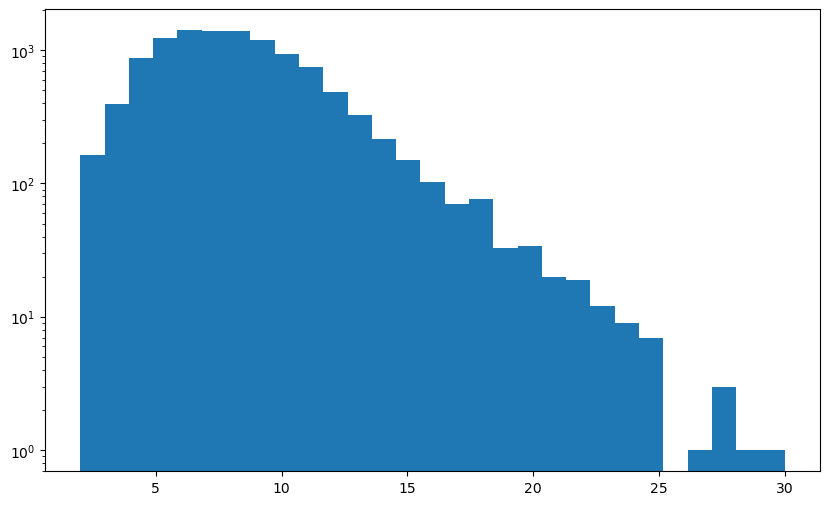

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plt.hist(word_lengths, bins=max(word_lengths)-min(word_lengths)+1)
ax.set_yscale("log")

In [26]:
text = "word1<p>  word2</p>"
BeautifulSoup(text, 'html.parser').get_text(separator=" ", strip=True).strip()

'word1 word2'

**Fixing language field**

In [27]:
import nltk
# nltk.download('crubadan')
# nltk.download('punkt')

In [28]:
from nltk import classify
from nltk import textcat
detector = textcat.TextCat()

def detect_lang(text):
    try:
        return detector.guess_language(text)
    except:
        return ""

In [29]:
df_open_tasks.head(1)

,taskId,language,description,context,tenant_id,tenant_name,topic_name,topic_description,word_count
14837,2cJMUQ5g2Tl9P93e0tYmOT,NaN,Nennen Sie fünf Argumente für die ZHAW.,NaN,19.0,Marketing Grundlagen,NaN,NaN,7


In [31]:
#df_open_tasks["language"] = df_open_tasks["description"].apply(lambda text: detect_lang(text))
# df_open_tasks.to_csv("language_detected.csv", index_label=False)

In [79]:
df_open_tasks = pd.read_csv("language_detected.csv")

In [80]:
df_open_tasks["language"] = df_open_tasks["language"].str.strip()
df_open_tasks.language.unique()

array(['deu', 'fra', 'eng', 'ita', 'fur', 'nds', 'vec', 'lnc', 'por',
       'ukr', 'lmo', 'nob', 'pdc', 'gsw', 'cat', 'glg', 'ssw', 'dan',
       'ksh', 'sot', 'ltz'], dtype=object)

In [81]:
df_translator = df_open_tasks[df_open_tasks["tenant_name"] == "DataEnricher"]
df_open_tasks = df_open_tasks[df_open_tasks["tenant_name"] != "DataEnricher"]

idx = df_open_tasks[df_open_tasks["tenant_name"].isin(["connectsolutions_fr", "connectsolutions_it"])].index
df_open_tasks = df_open_tasks.drop(idx)

filtered_df = df_open_tasks[df_open_tasks['description'].str.contains('translate', case=False)]
idx = filtered_df.index
df_translator = pd.concat([df_translator, filtered_df])
df_open_tasks = df_open_tasks.drop(idx)

filtered_df = df_open_tasks[df_open_tasks['description'].str.contains('übersetzen', case=False)]
idx = filtered_df.index
df_translator = pd.concat([df_translator, filtered_df])
df_open_tasks = df_open_tasks.drop(idx)

filtered_df = df_open_tasks[df_open_tasks['description'].str.contains('übersetze', case=False)]
idx = filtered_df.index
df_translator = pd.concat([df_translator, filtered_df])
df_open_tasks = df_open_tasks.drop(idx)

In [84]:
df_open_tasks.language.unique()

array(['deu', 'eng', 'fra', 'nds', 'ita', 'ukr', 'por', 'cat', 'glg',
       'gsw', 'ksh', 'ltz'], dtype=object)

In [82]:
pd.set_option("display.max_rows", None)
df_eng = df_open_tasks[df_open_tasks["language"] == "eng"]
df_deu = df_open_tasks[df_open_tasks["language"] == "deu"]

In [83]:
idx = df_eng[df_eng["tenant_name"].isin(["connectsolutions_de", "Marketing Grundlagen"])].index
df_eng = df_eng.drop(idx)
df_deu = pd.concat([df_deu, df_open_tasks.loc[idx]])

In [89]:
# df_eng.sort_values(by="tenant_name")

In [90]:
# df_deu.sort_values(by="tenant_name")

In [95]:
# df_open_tasks[~df_open_tasks["language"].isin(["deu", "eng"])].sort_values(by="language")

In [86]:
idx = df_open_tasks[df_open_tasks["language"].isin(["nds", "gsw", "ltz", "ksh"])].index
df_deu = pd.concat([df_deu, df_open_tasks.loc[idx]])

In [87]:
df_eng["language"] = "eng" 
df_deu["language"] = "deu" 

In [91]:
df_eng.to_csv("data/open_tasks_EN.csv", index_label=False)

In [92]:
df_deu.to_csv("data/open_tasks_DE.csv", index_label=False)

In [93]:
df_translator.to_csv("data/translate_tasks.csv", index_label=False)

In [94]:
len(df_eng), len(df_deu), len(df_translator)

(283, 1570, 646)